In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazonreviews/test.ft.txt.bz2
/kaggle/input/amazonreviews/train.ft.txt.bz2


### Loading Necessary Libraries

In [2]:
import spacy
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import os
import bz2

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2025-06-15 13:25:06.846145: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749993907.043151      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749993907.102443      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading the datasets

In [3]:
train_path = '/kaggle/input/amazonreviews/train.ft.txt.bz2'
test_path = '/kaggle/input/amazonreviews/test.ft.txt.bz2'

def load_data(file_path):
    texts = []
    labels = []
    with bz2.open(file_path, 'rt', encoding='utf-8') as f:
        for line in f:
            label = int(line[9]) - 1  # __label__1 or __label__2 becomes 0 or 1
            text = line[11:].strip()
            texts.append(text)
            labels.append(label)
    return pd.DataFrame({'text': texts, 'label': labels})

train_df = load_data(train_path)
test_df = load_data(test_path)

In [4]:
train_df.head()

,text,label
0,Stuning even for the non-gamer: This sound tra...,1
1,The best soundtrack ever to anything.: I'm rea...,1
2,Amazing!: This soundtrack is my favorite music...,1
3,Excellent Soundtrack: I truly like this soundt...,1
4,"Remember, Pull Your Jaw Off The Floor After He...",1


In [5]:
test_df.head()

,text,label
0,Great CD: My lovely Pat has one of the GREAT v...,1
1,One of the best game music soundtracks - for a...,1
2,Batteries died within a year ...: I bought thi...,0
3,"works fine, but Maha Energy is better: Check o...",1
4,Great for the non-audiophile: Reviewed quite a...,1


### Text Processing

In [6]:
def preprocess_text(text):
    """
    Preprocesses the input text by converting to lowercase, removing punctuation and digits,
    splitting into words, removing stop words, and applying lemmatization.

    Args:
        text (str): The input text to be preprocessed.

    Returns:
        str: The preprocessed text.
    """
    # Convert the text to lowercase
    text = text.lower()

    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text).strip()   # Remove punctuation
    text = re.sub(r'\d+', '', text).strip()        # Remove digits

    # Split the text into words
    words = text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))

    # Remove both general stop words and false-meaning words
    words = [word for word in words if word not in stop_words]

    # Apply lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(words)

In [8]:
# Cleaning the text by applying the preprocess_text function to each review in the 'review' column
train_df['text'] = train_df['text'].apply(preprocess_text)  # Clean the text in the train DataFrame
train_df.head()

,text,label
0,stuning even nongamer sound track beautiful pa...,1
1,best soundtrack ever anything im reading lot r...,1
2,amazing soundtrack favorite music time hand in...,1
3,excellent soundtrack truly like soundtrack enj...,1
4,remember pull jaw floor hearing youve played g...,1


In [9]:
test_df['text'] = test_df['text'].apply(preprocess_text)  # Clean the text in the test DataFrame
test_df.head()

,text,label
0,great cd lovely pat one great voice generation...,1
1,one best game music soundtrack game didnt real...,1
2,battery died within year bought charger jul wo...,0
3,work fine maha energy better check maha energy...,1
4,great nonaudiophile reviewed quite bit combo p...,1


### Named Entity Recognition (NER)

In [10]:
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    products = [ent.text for ent in doc.ents if ent.label_ == 'PRODUCT']
    brands = [ent.text for ent in doc.ents if ent.label_ == 'ORG' or ent.label_ == 'PRODUCT'] # Using ORG and PRODUCT for potential brand mentions
    return products, brands

In [11]:
# Sample a subset of the DataFrame
sample_size = 100000
if len(train_df) > sample_size:
  sampled_train_df = train_df.sample(n=sample_size, random_state=42).copy() # Use .copy() to avoid SettingWithCopyWarning
else:
  sampled_train_df = train_df.copy()

# Apply entity extraction to the sampled data
sampled_train_df['products'], sampled_train_df['brands'] = zip(*sampled_train_df['text'].apply(extract_entities))

# Create the list of product and brand combinations
product_brand_list = []
for index, row in sampled_train_df.iterrows():
  for product in row['products']:
    for brand in row['brands']:
      product_brand_list.append({'product': product, 'brand': brand})

In [12]:
product_brand_df = pd.DataFrame(product_brand_list)

print(product_brand_df.head())

    product     brand
0    hondas    hondas
1  zucchero  zucchero
2  muy buen        un
3  muy buen  muy buen
4      cole      cole


In [13]:
product_brand_df.shape

(881, 2)

#### Top 10 products

In [14]:
product_brand_df['product'].value_counts(normalize=True, ascending=False).head(10)

product
cole               0.129398
atlantis           0.083995
google             0.041998
mosaic             0.024972
jimmy              0.023837
cherokee           0.020431
viejo consumido    0.019296
viejo de años      0.019296
martin             0.017026
ccd                0.013621
Name: proportion, dtype: float64

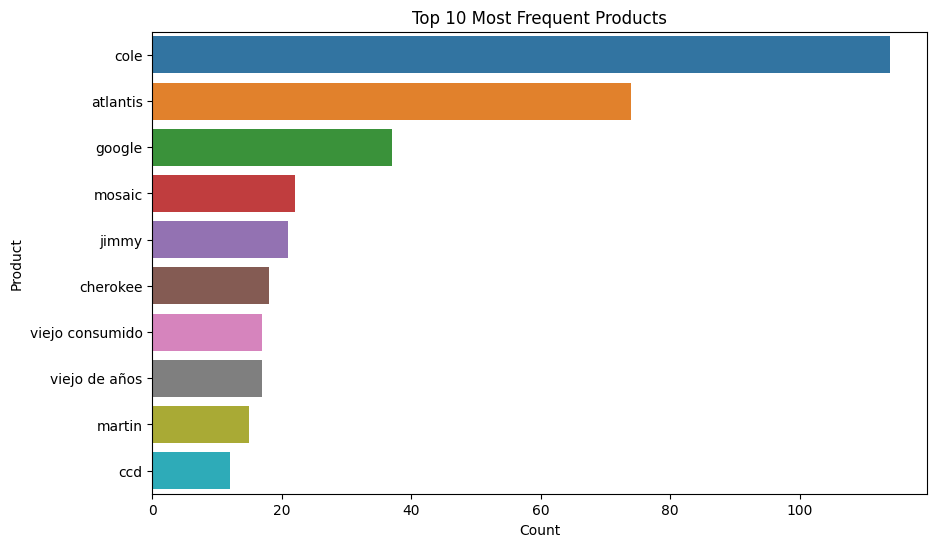

In [15]:
# Visualize the top 10 most frequent products
plt.figure(figsize=(10, 6))
sns.countplot(y='product', data=product_brand_df, order=product_brand_df['product'].value_counts().index[:10])
plt.title('Top 10 Most Frequent Products')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show();

#### Top 10 brands

In [16]:
product_brand_df['brand'].value_counts(normalize=True, ascending=False).head(10)

brand
cole        0.110102
atlantis    0.070375
un          0.032917
google      0.032917
mosaic      0.023837
sony        0.023837
martin      0.022701
jimmy       0.020431
cherokee    0.020431
toyota      0.012486
Name: proportion, dtype: float64

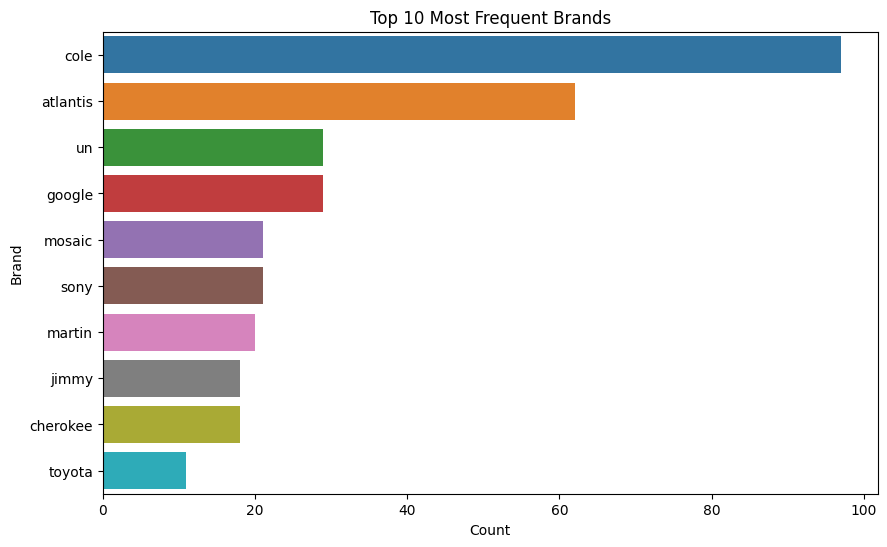

In [17]:
# Visualize the top 10 most frequent brands
plt.figure(figsize=(10, 6))
sns.countplot(y='brand', data=product_brand_df, order=product_brand_df['brand'].value_counts().index[:10])
plt.title('Top 10 Most Frequent Brands')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.show();

### Label Counts

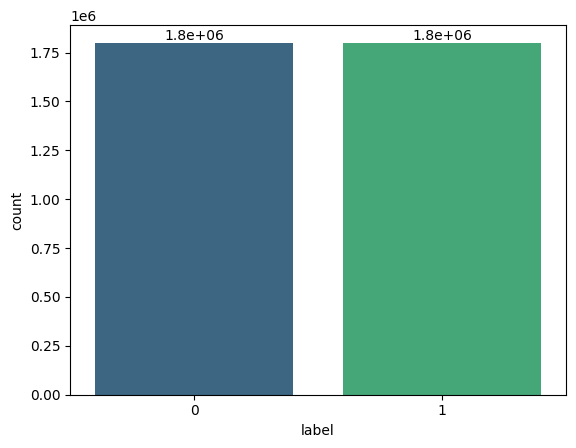

In [18]:
ax = sns.countplot(data =train_df, x = "label", palette= 'viridis')
ax.bar_label(ax.containers[0])
plt.show();

### Data Processing

#### Splitting Data

In [19]:
X=train_df['text']
y=train_df['label']

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

tokn=Tokenizer(num_words=20000)
tokn.fit_on_texts(X_train)

tokenized_sentences = tokn.texts_to_sequences(X_train)

tkn_tst=tokn.texts_to_sequences(X_test)

X_train_prcs = pad_sequences(tokenized_sentences, maxlen=100)

X_test_prcs=pad_sequences(tkn_tst, maxlen=100)

In [21]:
y_train = np.array(y_train, dtype=np.int32)
y_train = y_train - y_train.min()
y_train = utils.to_categorical(y_train, num_classes=2)
print(y_train[:1])
print(y_train.shape)

[[0. 1.]]
(2880000, 2)


In [22]:
y_test = np.array(y_test, dtype=np.int32)
y_test = y_test - y_test.min()

print(type(X_train_prcs), X_train_prcs.shape)
print(type(y_train), y_train.shape)

<class 'numpy.ndarray'> (2880000, 100)
<class 'numpy.ndarray'> (2880000, 2)


### Modeling

In [23]:
model=Sequential()
model.add(Embedding(input_dim=20000,output_dim=128,input_length=100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(64)) 
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

W0000 00:00:1749997193.398951      35 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [24]:
# Callback  
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    'best_model.keras', 
    save_best_only=True, 
    monitor='val_accuracy')

In [25]:
history = model.fit(
    X_train_prcs, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=1200,
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3158s 2s/step - accuracy: 0.8724 - loss: 0.2964 - val_accuracy: 0.9158 - val_loss: 0.2110
Epoch 2/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3031s 2s/step - accuracy: 0.9221 - loss: 0.1988 - val_accuracy: 0.9225 - val_loss: 0.1952
Epoch 3/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2978s 2s/step - accuracy: 0.9326 - loss: 0.1745 - val_accuracy: 0.9247 - val_loss: 0.1908
Epoch 4/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3069s 2s/step - accuracy: 0.9403 - loss: 0.1574 - val_accuracy: 0.9247 - val_loss: 0.1934
Epoch 5/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 3092s 2s/step - accuracy: 0.9482 - loss: 0.1391 - val_accuracy: 0.9237 - val_loss: 0.1981
Epoch 6/10
1920/1920 ━━━━━━━━━━━━━━━━━━━━ 2978s 2s/step - accuracy: 0.9551 - loss: 0.1227 - val_accuracy: 0.9219 - val_loss: 0.2131


In [26]:
y_train_pred = model.predict(X_train_prcs)

y_train_pred = np.argmax(y_train_pred, axis=1)  
y_train_pred[:11]

90000/90000 ━━━━━━━━━━━━━━━━━━━━ 3549s 39ms/step


array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

### Model Evaluation

In [27]:
print(classification_report(np.argmax(y_train, axis=1), y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94   1440241
           1       0.94      0.94      0.94   1439759

    accuracy                           0.94   2880000
   macro avg       0.94      0.94      0.94   2880000
weighted avg       0.94      0.94      0.94   2880000



Text(0.5, 1.0, 'Confusion Matrix')

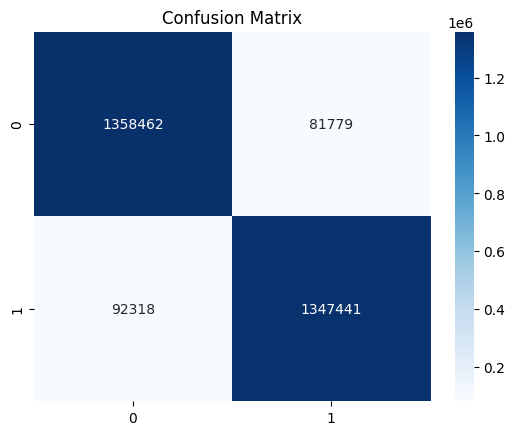

In [28]:
sns.heatmap(confusion_matrix(np.argmax(y_train, axis=1),y_train_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

In [29]:
y_pred = model.predict(X_test_prcs)

y_pred = np.argmax(y_pred, axis=1)

22500/22500 ━━━━━━━━━━━━━━━━━━━━ 857s 38ms/step


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92    359759
           1       0.93      0.92      0.92    360241

    accuracy                           0.92    720000
   macro avg       0.92      0.92      0.92    720000
weighted avg       0.92      0.92      0.92    720000



Text(0.5, 1.0, 'Confusion Matrix')

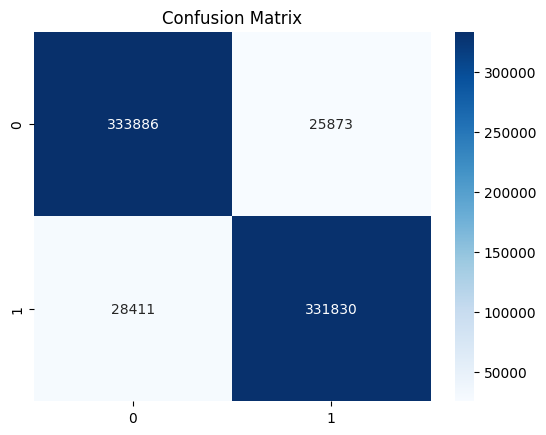

In [31]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

In [32]:
Token_test=tokn.texts_to_sequences(test_df.text)

Test_process=pad_sequences(Token_test, maxlen=100)

Test_true = np.array(test_df.label, dtype=np.int32)
Test_true = Test_true - Test_true.min()

Test_process.shape

Test_pred = model.predict(Test_process)

Test_pred = np.argmax(Test_pred, axis=1)

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 520s 42ms/step


In [33]:
print(classification_report(Test_true, Test_pred))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92    200000
           1       0.93      0.92      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



Text(0.5, 1.0, 'Confusion Matrix')

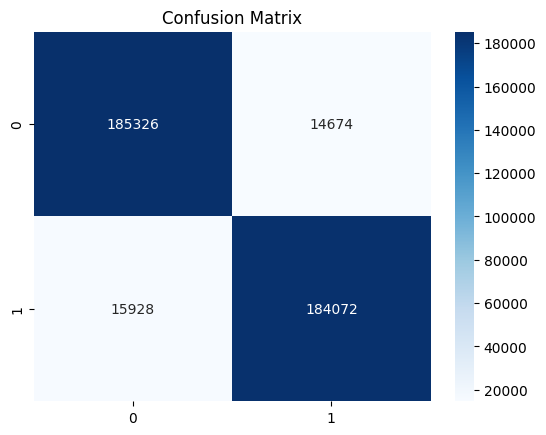

In [34]:
sns.heatmap(confusion_matrix(Test_true, Test_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')